### Partiamo dal solito BreastCancer dataset e modello (codice sotto)
### Scrivi TRE callbacks
- (1) un batch logger che salvi la loss ad ogni batch
- (2) un learning rate scheduler che setti il LR a 0.001 in epoche pari e 0.005 in epoche dispari
- (3) un early stopper che fermi il training se la validation accuracy sale sopra .9
### Fai girare il training con 100 epoche e le tre callbacks
### Visualizza, allineandole, le loss per batch ed epoca

In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import clear_session
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer,Dense

In [3]:
bc = datasets.load_breast_cancer()
X = bc.data
y = bc.target

In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25, stratify=y)

In [5]:
def get_model():
    model = Sequential()
    model.add(Dense(units=16, activation='relu', input_dim=30))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
%%time
clear_session()
model = get_model()
history = model.fit(X_train, y_train, epochs=5,
            validation_data=(X_test, y_test), verbose=0);

CPU times: total: 859 ms
Wall time: 2.25 s


### Da qui in poi!

In [7]:
#Explore methods available in Callback superclass
cb = tf.keras.callbacks.Callback()
[x for x in dir(cb) if not x.startswith("_")]

['model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params']

In [8]:
class MyCallBacks(tf.keras.callbacks.Callback):    
    def __init__(self):
        self.batch_loss = []
        
#     def on_train_begin(self,*args,**kwargs):
#         print(dir(self.model))
    
    def on_train_batch_end(self, batch, logs):
        self.batch_loss.append(logs["loss"])
        
    def on_epoch_begin(self, epoch, logs=None):
        if(epoch % 2): #odd
            self.model.optimizer.learning_rate = 0.005
        else: #even
            self.model.optimizer.learning_rate = 0.001
        print(f"Begin epoch {epoch} LR = {self.model.optimizer.learning_rate.numpy()}" )
    
    def on_epoch_end(self, epoch, logs):
        self.model.stop_training = logs["val_accuracy"] >= 0.9
        print(f"At end of epoch {epoch}, stop_training is: {self.model.stop_training}")
        print(f"val_accuracy = { logs['val_accuracy'] }")
#         test_accuracy = logs["val_accuracy"]
#         if(test_accuracy >= 0.9):
#             self.model.stop_training = True
        
        

In [9]:
clear_session()
model = get_model()
cb = MyCallBacks()
history = model.fit(X_train, y_train, epochs=100,
            validation_data=(X_test, y_test), verbose=0,
                   callbacks=[cb]);

Begin epoch 0 LR = 0.0010000000474974513
At end of epoch 0, stop_training is: False
val_accuracy = 0.6293706297874451
Begin epoch 1 LR = 0.004999999888241291
At end of epoch 1, stop_training is: False
val_accuracy = 0.37062937021255493
Begin epoch 2 LR = 0.0010000000474974513
At end of epoch 2, stop_training is: False
val_accuracy = 0.37062937021255493
Begin epoch 3 LR = 0.004999999888241291
At end of epoch 3, stop_training is: False
val_accuracy = 0.37062937021255493
Begin epoch 4 LR = 0.0010000000474974513
At end of epoch 4, stop_training is: False
val_accuracy = 0.6363636255264282
Begin epoch 5 LR = 0.004999999888241291
At end of epoch 5, stop_training is: False
val_accuracy = 0.37062937021255493
Begin epoch 6 LR = 0.0010000000474974513
At end of epoch 6, stop_training is: False
val_accuracy = 0.8251748085021973
Begin epoch 7 LR = 0.004999999888241291
At end of epoch 7, stop_training is: False
val_accuracy = 0.7972028255462646
Begin epoch 8 LR = 0.0010000000474974513
At end of epoch

In [10]:
print(f"batch_loss size: {len(cb.batch_loss)}")
print(f"history epoch loss size: {len(history.history['loss'])}")

batch_loss size: 252
history epoch loss size: 18


### Plot learning curve 
Batch loss & epoch loss

In [14]:
#batch loss and epoch loss have different size -> let's stretch epoch loss
stretched = [[x]*14 for x in history.history["loss"]] #list of lists
flatten = [a for b in stretched for a in b] #list of numbers

#check
print(len(flatten))
print(len(cb.batch_loss))

252
252


Plot learning curves

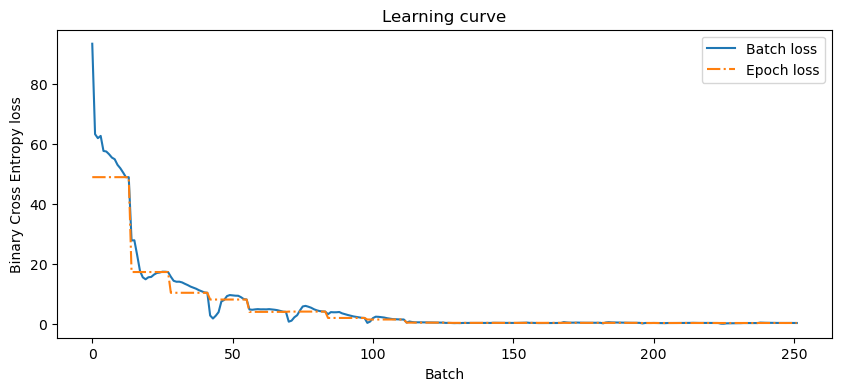

In [17]:
plt.figure(figsize=(10,4))
plt.plot(cb.batch_loss, label="Batch loss")
plt.plot(flatten,'-.', label="Epoch loss")
plt.xlabel("Batch")
plt.ylabel("Binary Cross Entropy loss")
plt.title("Learning curve")
plt.legend()
plt.show()